# Sex Classification using Periocular Images

---

*Note on the nomenclature in this project:*

*The word "sex" will be used throughout this project in place of the often incorrectly used "gender". Gender refers to characteristics assigned by cultural norms while sex are biological and physiologic characteristics.*

Need to think on this a bit more... If the model is picking up on certain periocular characteristics (applied makeup), an argument can be made for the use of the word gender here.

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Class Labels](#class)
  - 3.3. [Balance Dataset](#balance)
  - 3.4. [Image Normalization](#norm)
- 4.[**Train / Val / Test Split**](#split)
- 5.[**Exploratory Data Analysis (EDA)**](#eda)
- 6.[**Training Data Image Transformations / Augmentations**](#transforms)
- 7.[**Models**](#models)
  - 7.1. [Baseline Models](#baseline)
  - 7.2. [Deep Learning Models](#deep)
    - 7.2.1. [Shallow Feedforward Neural Network](#fnn)
    - 7.2.2. [Deep-ish Convolutional Neural Network](#cnn)
    - 7.2.3. [Deep Convolutional Neural Network](#dcnn)
- 8.[**Model Analysis and Feature Extraction Discussion**](#analysis)
- 9.[**Results**](#results)
- 10.[**Conclusion**](#conclusion)
  - 10.1. [Limitations](#limitations)
  - 10.2. [Future Work](#future)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


## 2. Setup <a name="setup"></a>

---

In [105]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as path_effects
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.decomposition import PCA

import tensorflow as tf

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [2]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, sklearn, tf, torch]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'sklearn'  using version: 1.3.2
<module 'tensorflow'  using version: 2.16.2
<module 'torch'  using version: 2.2.2


### 2.2. Importing the Data: <a name="dataimport"></a>

*Note: Two dataset characteristics were noticed during initial data import.*

1. Image sizes varied.
2. Numerically consecutive images showed left then right eyes of one individual. While it seems most images follow this pattern, some individuals only have one eye present where a number is then skipped. Unfortunately the pattern does not persist perfectly and it was noted that some individuals left and right eyes were not consecutively named (e.g. `\Female\68` ... `.\70`). This presents issues for splitting training and testing sets.

The fixes chosen to overcome these two issues:

1. The mean and median size of all images was shown to be ~ 56 x 56 pixels.
    - All images are to be resized to 56 x 56 and antialiased/resampled using `LANCZOS`.
2. Since naming conventions were not perfect in the creation of this dataset, it was decided to only use odd numbered images for the best chances at avoiding the same individual showing up in the dataset twice - mitigating data leakage between training and test sets.

In [3]:
def image_import(file_list, sex, image_size):
    '''
    Takes a list of image filenames and loads the images into a dictionary with the same filename(*).

    (*) Adds up to 4 leading zeros to the name if they are not present.
    
    Parameters:
        file_list: List of filenames in the form ['name.extension', ...]
        sex: String denoting the folder in ./data to find the images. ('Male' or 'Female')
        image_size: Integer, will all images resize to this parameter. 
            All images are different sizes, median/mean of dataset is 56x56.
    Returns:
        eyes_dict: Dictionary whose keys are the filename with leading zeros and value is a numpy array of the image.
    '''
    eyes_dict = {}
    # img_sizes = []
    for file in file_list:
        # Separate file extension and name.
        number, _ = file.split('.')
        number_new = number.zfill(4) # Add leading zeros.
        # Only take odd numbers to remove more than 1 eye per person.
        if int(number) % 2 == 1:
            img = Image.open(f'./Data/{sex}/{number}.jpg')
            # Used to check most common size.
            #img_sizes.append(np.asarray(img).shape[0])
            
            img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)
            eyes_dict[number_new] = np.asarray(img).flatten()

    return eyes_dict #, image_sizes

In [4]:
img_size = 56 # Used throughout notebook.

female_files = os.listdir('./Data/Female')
male_files = os.listdir('./Data/male')

eyes_female = image_import(female_files, 'Female', image_size=img_size)
eyes_male = image_import(male_files, 'Male', image_size=img_size)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Let's take a look at a random image first and make sure it's the right size and expected format.

(56, 56, 3)


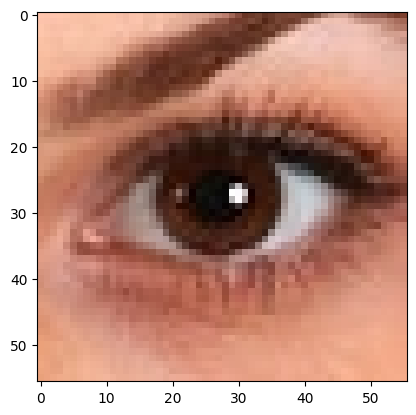

In [5]:
print(eyes_female['0011'].reshape(img_size,img_size,3).shape)
plt.imshow(Image.fromarray(eyes_female['0011'].reshape(img_size,img_size,3)))
plt.show()

Looks good - the shape of `(56, 56, 3)` indicates an 3-dimensional array representing RGB with no alpha channel.

### 3.2. Class Labels: <a name="class"></a>

Now, we should add the class labels to each image. This was made easier by keeping the two genders separate for now.

In [6]:
eyes_female_df = pd.DataFrame(eyes_female.items(), columns = ['eye_d', 'rgb_flat'])
eyes_male_df = pd.DataFrame(eyes_male.items(), columns = ['eye_d', 'rgb_flat'])

eyes_female_df['sex'] = 0
eyes_male_df['sex'] = 1

### 3.3. Balance Dataset: <a name="balance"></a>

Now, we can see if the target variable is balanced or not.

In [7]:
print(f'Female Sample Size: {len(eyes_female_df)}')
print(f'Male Sample Size: {len(eyes_male_df)}')

Female Sample Size: 2591
Male Sample Size: 3173


Ok this shows a fairly unbalanced dataset. This is important mind for when we do the train / val / test set splits and model evaluations.

In fact, to simplify things, we can balance the dataset by removing the extra male images by randomly sampling the male eyes without replacement up to the number of female eyes.

Then, the two dataframes will be combined into one.

In [8]:
# Balance classes, limiting the number of male eyes.
eyes_male_df = eyes_male_df.sample(n = len(eyes_female_df), random_state = 11, replace = False)

# Create dataframe with mixed sexes.
eyes_df = pd.concat([eyes_female_df, eyes_male_df]).reset_index(drop = True)
eyes_df

,eye_d,rgb_flat,sex
0,0823,"[216, 170, 136, 214, 168, 134, 212, 166, 133, ...",0
1,4217,"[141, 77, 49, 140, 76, 48, 138, 77, 48, 137, 7...",0
2,5109,"[244, 215, 199, 235, 206, 190, 165, 133, 118, ...",0
3,4571,"[237, 210, 193, 234, 207, 190, 234, 205, 189, ...",0
4,1409,"[175, 143, 130, 173, 141, 128, 172, 139, 130, ...",0
...,...,...,...
5177,0579,"[151, 112, 104, 149, 110, 103, 153, 114, 109, ...",1
5178,5191,"[210, 210, 210, 212, 212, 212, 209, 209, 209, ...",1
5179,0425,"[163, 118, 87, 164, 119, 88, 170, 125, 94, 166...",1
5180,5491,"[66, 44, 47, 48, 26, 30, 46, 25, 31, 44, 25, 3...",1


### 3.4. Image Normalization: <a name="norm"></a>

It's important to normalize the image pixel intensities for use in the neural networks.

In [9]:
eyes_df['norm_flat'] = eyes_df['rgb_flat'] / 255

In [10]:
# Function to reshape arrays for processes / models that require image array.
def flat_to_array(flat_array):
    '''
    Takes a dataframe column (series) and reshapes flat array to image array (H x W x C).
    '''
    return flat_array.reshape(img_size,img_size,3)

## 4. Train / Val / Test Split <a name="split"></a>

---

Split 
- Train = 70%
- Validation = 18%
- Test = 12%

In [11]:
# Train and Test
X_train, X_test = train_test_split(eyes_df, test_size = 0.30, shuffle = True, stratify = eyes_df.sex, random_state = 11)
# Validation from Test
X_test, X_val = train_test_split(X_test, test_size = 0.60, shuffle = True, stratify = X_test.sex, random_state = 11)

# Create y.
y_train = X_train.sex
y_val = X_val.sex
y_test = X_test.sex

# Drop y from X.
X_train = X_train.drop(columns = ['sex'])
X_val = X_val.drop(columns = ['sex'])
X_test = X_test.drop(columns = ['sex'])

print(f'Train Set Size: {len(X_train)}')
print(f'Validation Set Size: {len(X_val)}')
print(f'Test Set Size: {len(X_test)}')
print('\n##################\n')
print('Target Class Balance:')
print('----Train:\n', y_train.value_counts())
print('----Validation:\n', y_val.value_counts())
print('----Test:\n', y_test.value_counts())

Train Set Size: 3627
Validation Set Size: 933
Test Set Size: 622

##################

Target Class Balance:
----Train:
 sex
0    1814
1    1813
Name: count, dtype: int64
----Validation:
 sex
1    467
0    466
Name: count, dtype: int64
----Test:
 sex
0    311
1    311
Name: count, dtype: int64


## 5. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

In [12]:
# Colors for the target classes to stay consistent.
cmap_sex = {'Female' :'#439A86', 'Male': '#423e80'}

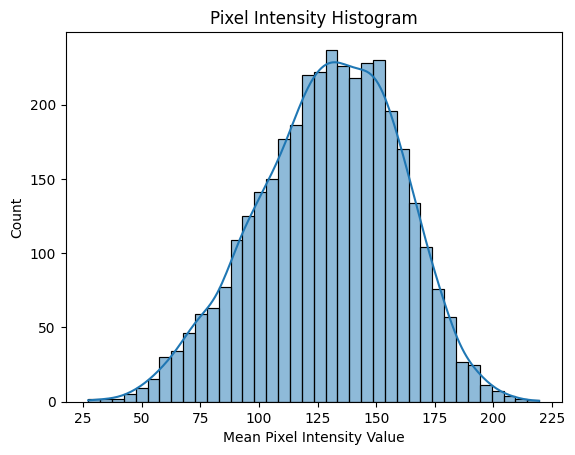

In [13]:
# Find the mean pixel intensity of each image (down to one value along all axes).
mean_intensity = X_train.rgb_flat.apply(flat_to_array).apply(np.mean)

sns.histplot(mean_intensity, binwidth = 5, kde = True)
plt.xlabel('Mean Pixel Intensity Value')
plt.title('Pixel Intensity Histogram')
plt.show()

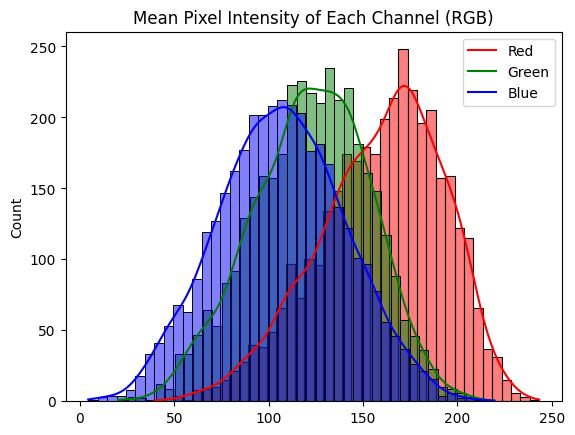

In [14]:
mean_intensity_rgb = np.stack(X_train.rgb_flat.apply(flat_to_array).apply(np.mean, axis = 1).apply(np.mean, axis = 0).to_numpy())

# Plot the distribution of the mean intensities of individual RGB channels.
rgb_dict = {0:'Red', 1:'Green', 2:'Blue'}
for i in rgb_dict.keys():
    sns.histplot(mean_intensity_rgb[:,i], color = rgb_dict[i], binwidth = 5, kde = True)#, ax = ax[i])
plt.title('Mean Pixel Intensity of Each Channel (RGB)')
plt.legend(list(rgb_dict.values()))
plt.show()

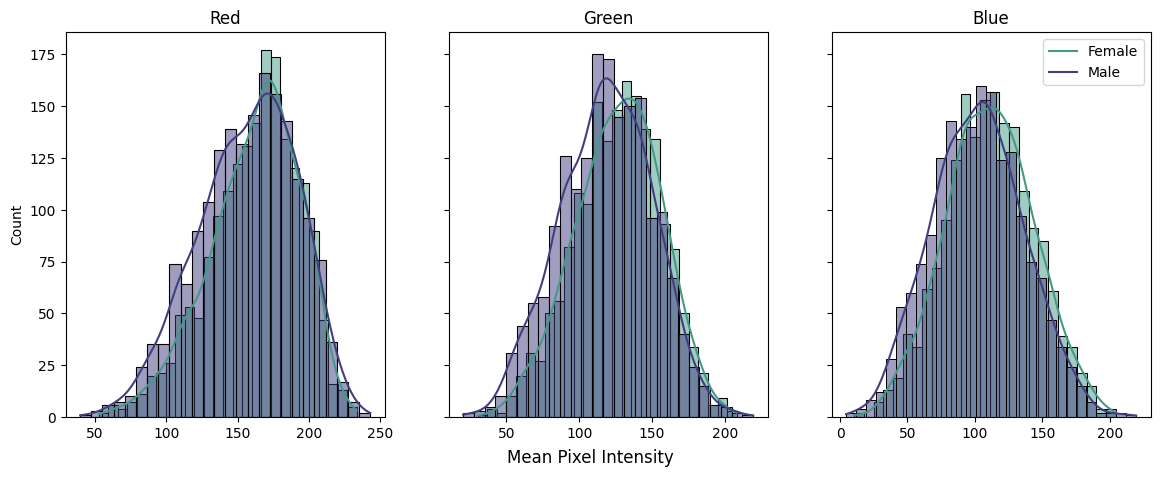

In [15]:
# Create a mask of the target class.
mask_sex = y_train == 0

# Plot the distribution of the mean intensities of individual channels in both Males and Females.
fig, ax = plt.subplots(1, 3, figsize = (14, 5), sharey = True)
for i in range(3):
    # Female
    sns.histplot(mean_intensity_rgb[:,i][mask_sex], kde = True, color = cmap_sex['Female'], ax = ax[i])
    # Male
    sns.histplot(mean_intensity_rgb[:,i][~mask_sex], kde = True, color = cmap_sex['Male'], ax = ax[i])
    ax[i].set_title(f'{rgb_dict[i]}')
fig.supxlabel('Mean Pixel Intensity')
plt.legend(['Female', 'Male'])
plt.show()

## 6. Training Data Image Transformations / Augmentations <a name="transforms"></a>

---

With this small dataset and image sizes, I am opting to create a manual "offline" data augmentation pipeline instead of using the Pytorch, Tensorflow, Albumentations, etc dataloaders and image transformation functions. This choice is being made with the following in mind:

1. Ensures consistency of training between model types and especially python frameworks (TensorFlow / Pytorch).
2. Tighter controls on the specific transformations.
3. Enables tighter random seed controls for reproducibility and comparisons.
4. The memory to store these image transformations are negligible for this dataset size.

Develop Image Transformation/Augmentation Function for training set.

(Random intensity, horizontal and vertical mirroring, rotations, subset crop of image + padding, etc)

In [16]:
BATCH_SIZE = 16

In [17]:
X_ds_train = tf.data.Dataset.from_tensor_slices(np.stack(X_train.norm_flat.values).reshape(len(X_train), img_size, img_size, 3))
y_ds_train = tf.data.Dataset.from_tensor_slices(y_train.values)

ds_train = tf.data.Dataset.zip((X_ds_train, y_ds_train))

# # Batch the dataset
# ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE)

In [18]:
X_ds_val = tf.data.Dataset.from_tensor_slices(np.stack(X_val.norm_flat.values).reshape(len(X_val), img_size, img_size, 3))
y_ds_val = tf.data.Dataset.from_tensor_slices(y_val.values)

ds_val = tf.data.Dataset.zip((X_ds_val, y_ds_val))

# # Batch the dataset
# ds_val = ds_val.shuffle(1000).batch(BATCH_SIZE)

In [19]:
# Transformation object.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomCrop(img_size, img_size),
    tf.keras.layers.RandomBrightness(0.4, value_range = (0, 1)),
    # Random saturation using lambda.
    tf.keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower = 0, upper = 3))
    ])

# Autotune to set buffer size.
AUTOTUNE = tf.data.AUTOTUNE

# Function to setup the transformations within the dataloader.
def prepare(ds, shuffle = False, augment = False):
  if shuffle:
    ds = ds.shuffle(1000)

  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    
  # Prefetch buffer necessary here to ensure proper loading during training.
  return ds.prefetch(buffer_size = AUTOTUNE)

In [20]:
ds_train_transformed = prepare(ds_train, shuffle = True, augment = True)
ds_train_transformed = ds_train_transformed.batch(BATCH_SIZE)

ds_val = prepare(ds_val, shuffle = False, augment = False)
ds_val = ds_val.batch(BATCH_SIZE)

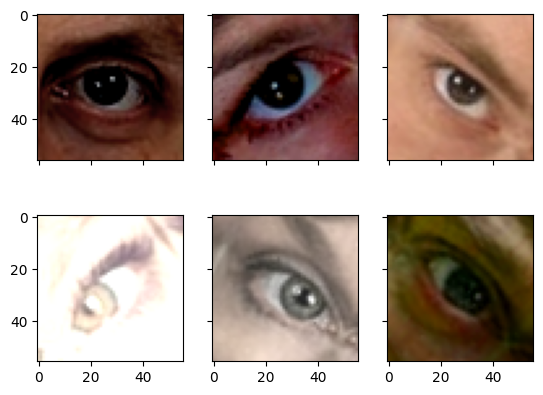

In [21]:
for img, label in ds_train_transformed:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = (img.numpy() * 255).astype(np.uint8)
    for i in range(6):
        ax[i // 3, i % 3].imshow(img[i])
    break

## 7. Models <a name="models"></a>

---

### 7.0. Model Helper Functions:

In [22]:
def set_region_overlay(model_history_df, x_offset):
    x_mid = ((model_history_df.index.stop-1) + model_history_df.val_loss.idxmin()) / 2
    plt.text(x = x_mid - x_offset,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = 'Early Stop',
             rotation = 'horizontal',
             weight = 'extra bold',
             fontsize = 'large',
             antialiased = True,
             alpha = 1,
             c = 'white',
             bbox = dict(facecolor = 'black', edgecolor = 'black', boxstyle = 'round', alpha = 0.5))
    return None

def plot_TF_training_history(model_history_df):

    # Find all epochs that callback ReduceLROnPlateau() occurred.
    lr_change = model_history_df.learning_rate.shift(-1) != model_history_df.learning_rate

    # Create color map and lines style map for train/val
    plot_maps = {'cmap': {'accuracy': '#653096',
                        'loss': '#653096',
                        'val_accuracy': '#004a54',
                        'val_loss': '#004a54'},
                'dashmap': {'accuracy': '',
                            'loss': (2,1),
                            'val_accuracy': '',
                            'val_loss': (2,1)}}

    # Plot
    fig, ax = plt.subplots(figsize = (10,6))
    ax = sns.lineplot(model_history_df.drop(columns = ['learning_rate']).iloc[1:], palette = plot_maps['cmap'], dashes = plot_maps['dashmap'])
    ax.set_xlabel('Epoch')

    # Create secondary x-axis for Learning Rate changes.
    sec_ax = ax.secondary_xaxis('top')
    sec_ax.set_xticks(model_history_df[lr_change].index[:-1])
    sec_ax.set_xticklabels([f'{x:.1e}' for x in model_history_df[lr_change].learning_rate[1:]])
    sec_ax.tick_params(axis = 'x', which = 'major', labelsize = 7)
    sec_ax.set_xlabel('Learning Rate Reductions')

    # Create vertical line for each LR change.
    for epoch in (model_history_df[lr_change].index[:-1]):
        plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
    # Create lines for best epoch/val_loss.
    plt.axvline(x = (model_history_df.val_loss.idxmin()), c = '#f54260', ls = (0, (3,1,1,1)))
    plt.axhline(y = (model_history_df.val_loss.min()), c = '#f54260', alpha = 0.3, ls = (0, (3,1,1,1)))
    # Grey out epochs after early stop.
    plt.axvspan(model_history_df.val_loss.idxmin(), model_history_df.index.stop-1, facecolor = 'black', alpha = 0.25)
    plt.margins(x = 0)
    set_region_overlay(model_history_df, 5)

    plt.legend()
    plt.show()
    return None

### 7.1. Baseline Models: <a name="baseline"></a>

**Random Chance Baseline**

In [23]:
1/2

0.5

**K-Nearest Neighbors (KNN) as Baseline**

Since this dataset contains all eyes that are mostly centered in the same position, KNN is a quick and easy model to implement and compare more complex methods against.

In [137]:
# TODO: Implement KNN discriminant plot from sklearn.
mod_knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', algorithm = 'brute', p = 2)
mod_knn.fit(np.stack(X_train.norm_flat), y_train)

y_pred_val_knn = mod_knn.predict(np.stack(X_val.norm_flat))
accuracy_score(y_val, y_pred_val_knn)

0.7738478027867095

In [103]:
y_pred_knn_proba = mod_knn.predict_proba(np.stack(X_test.norm_flat))
y_pred_knn = mod_knn.predict(np.stack(X_test.norm_flat))

### 7.2. Deep Learning Models: <a name="deep"></a>

#### 7.2.1. Shallow Feedforward Neural Network (FNN): <a name="fnn"></a>

In [26]:
mod_fnn = tf.keras.Sequential([
    tf.keras.Input(shape = (img_size, img_size, 3), name = 'Imput Image'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, name = 'Predictions')])

mod_fnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,817,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,883,330 (18.63 MB)

 Trainable params: 4,883,330 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Adam
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

In [27]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'adam'
val_freq = 1
n_epochs = 250
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [28]:
mod_fnn.compile(optimizer = optimizer_param, loss = loss_fx, metrics = ['accuracy'])

mod_fnn_hist = mod_fnn.fit(
    ds_train_transformed,
    batch_size = BATCH_SIZE,
    epochs = n_epochs,
    verbose = "auto",
    callbacks = [early_stop, reduce_lr_plateau],
    #validation_split = 0.0,
    validation_data = ds_val,
    shuffle = True,
    class_weight = None,
    sample_weight = None,
    initial_epoch = 0,
    steps_per_epoch = None,
    validation_steps = None,
    validation_batch_size = None,
    validation_freq = val_freq)

Epoch 1/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5102 - loss: 2.0908 - val_accuracy: 0.5005 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 2/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5325 - loss: 0.7418 - val_accuracy: 0.6827 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 3/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5404 - loss: 0.6942 - val_accuracy: 0.5198 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 4/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5795 - loss: 0.6727 - val_accuracy: 0.7170 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 5/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6305 - loss: 0.6421 - val_accuracy: 0.7117 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 6/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6698 - loss: 0.6175 - val_accuracy: 0.7299 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 7/250
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6634 - l

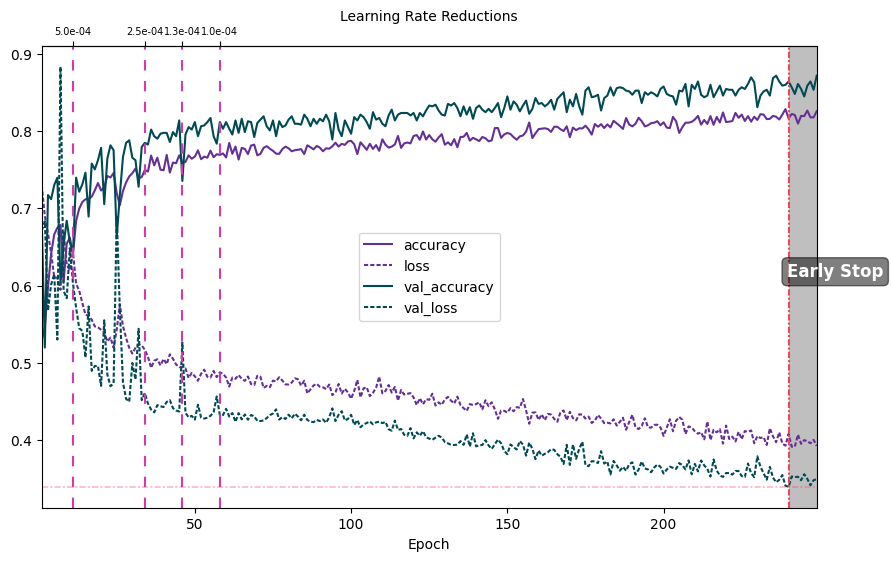

In [29]:
# Create dataframe of model fit history.
mod_fnn_hist_df = pd.DataFrame().from_dict(mod_fnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_fnn_hist_df)

In [136]:
y_pred_val_fnn_proba = mod_fnn.predict(ds_val, verbose = "auto", callbacks = None)
y_pred_val_fnn = y_pred_val_fnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_fnn)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.8638799571275455

In [31]:
y_pred_fnn_proba = mod_fnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_fnn = y_pred_fnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#### 7.2.2. Deep-ish Convolutional Neural Network (CNN): <a name="cnn"></a>

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Stochastic Gradient Descent (SGD)
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

Padded+Dropout(after 2nd conv2d)+Dense(128):
- 64,5,5 | 2,2 | 32,5,5 | 2,2 | Dense(128) = 0.9269183922046285

3x3s:
- 32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense = 0.925700365408039
- 32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense > 256 dense = 0.9147381242387332
- 32 (2,2,s=2) > 64 (2,2,s=2) > 256 dense > drop 0.1 > 256 dense = 0.9001218026796589

- 16 (2,2,s=2) > 32 (2,2,s=2) > 1024 dense = 0.9171741778319124 (Shows some 93 potential)

3 Layers on 3nd conv:
- 16, 32, 1024 = 0.9269183922046285 & 0.9330085261875761
- 16, 32, 512 == 0.9244823386114495
- 32, 64, 1024 = 0.9183922046285018

Talk about 5x5 vs 3x3 conv filters and how (with a stride of one) 2 3x3 = 1 5x5 but reduces parameters substantially. (Same receptive field)

In all cases, pooling helps to make the representation approximately invariant to small translations of the input. Invariance to translation means that if we translate the input by a small amount, the values of most of the pooled outputs do not change. See ﬁgure 9.8 for an example of how this works. Invariance to local translation can be a useful property if we care more about whether some feature is present than exactly where it is.

In [32]:
mod_cnn = tf.keras.models.Sequential([
    tf.keras.Input(shape = (img_size,img_size,3), name = 'Image Array'),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, name = 'Predictions')])
mod_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     6,423,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,501,106 (28.61 MB)

 Trainable params: 7,501,106 (28.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'sgd'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

In [34]:
mod_cnn.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_cnn_hist = mod_cnn.fit(ds_train_transformed,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4943 - loss: 0.6959 - val_accuracy: 0.5005 - val_loss: 0.6926 - learning_rate: 0.0100
Epoch 2/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5145 - loss: 0.6932 - val_accuracy: 0.6174 - val_loss: 0.6900 - learning_rate: 0.0100
Epoch 3/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5291 - loss: 0.6912 - val_accuracy: 0.5391 - val_loss: 0.6877 - learning_rate: 0.0100
Epoch 4/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5197 - loss: 0.6919 - val_accuracy: 0.5702 - val_loss: 0.6846 - learning_rate: 0.0100
Epoch 5/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5552 - loss: 0.6864 - val_accuracy: 0.5756 - val_loss: 0.6774 - learning_rate: 0.0100
Epoch 6/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5554 - loss: 0.6835 - val_accuracy: 0.6785 - val_loss: 0.6529 - learning_rate: 0.0100
Epoch 7/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5966 - l

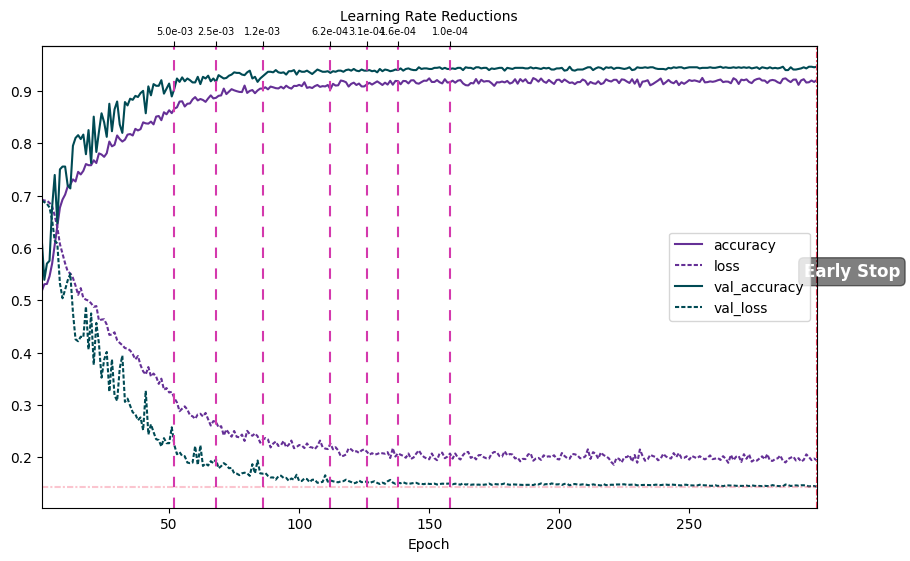

In [35]:
# Create dataframe of model fit history.
mod_cnn_hist_df = pd.DataFrame().from_dict(mod_cnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_cnn_hist_df)

In [36]:
y_pred_val_cnn_proba = mod_cnn.predict(np.stack(X_val.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_val_cnn = y_pred_val_cnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_cnn)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


0.9464094319399786

In [37]:
y_pred_cnn_proba = mod_cnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_cnn = y_pred_cnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


#### 7.2.3. Deep Convolutional Neural Network (DCNN): <a name="dcnn"></a>

In [63]:
# mod_dcnn = tf.keras.models.Sequential([
#     tf.keras.Input(shape = (img_size,img_size,3), name = 'Image Array'),
#     tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.MaxPooling2D((2,2), strides = 2),

#     tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.MaxPooling2D((2,2), strides = 2),

#     tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
#     tf.keras.layers.MaxPooling2D((2,2), strides = 2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(2048, activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2048, activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2, name = 'Predictions')])
# mod_dcnn.summary()

# Residual block with identity shortcut (no downsampling)
def residual_block(x, filters, downsample = False):
    shortcut = x

    # Downsample if required, i.e., if spatial dimensions need to be reduced
    strides = (2, 2) if downsample else (1, 1)

    # First convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), strides = strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # If downsample is True, we need to apply a convolution to the shortcut as well
    if downsample:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size = (1, 1), strides = (2, 2), padding = 'same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Add the shortcut (input) to the output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

# Function to create ResNet-50 like architecture
def build_resnet50(input_shape = (img_size, img_size, 3)):
    inputs = tf.keras.Input(shape = input_shape)

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same')(x)

    # First residual block (3 blocks with 64 filters)
    for _ in range(3):
        x = residual_block(x, 64)

    # Second residual block (4 blocks with 128 filters, first block downsamples)
    x = residual_block(x, 128, downsample = True)
    for _ in range(3):
        x = residual_block(x, 128)

    # Third residual block (6 blocks with 256 filters, first block downsamples)
    x = residual_block(x, 256, downsample = True)
    for _ in range(5):
        x = residual_block(x, 256)

    # Fourth residual block (3 blocks with 512 filters, first block downsamples)
    x = residual_block(x, 512, downsample = True)
    for _ in range(2):
        x = residual_block(x, 512)

    # Global average pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(2, name = 'Predictions')(x)

    # Create model
    model = tf.keras.Model(inputs, outputs)
    return model

# Create the ResNet-50 model
mod_dcnn = build_resnet50(input_shape=(img_size, img_size, 3))
mod_dcnn.summary()

loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'sgd'
val_freq = 1
n_epochs = 300
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                         factor = 0.5,
                                                         patience = 5,
                                                         cooldown = 8,
                                                         min_lr = 0.0001,
                                                         verbose = 1)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 56, 56, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 28, 28,    │      4,864 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_66 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 14, 14,    │          0 │ re_lu_66[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 14, 14,    │     36,928 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_67 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 14, 14,    │     36,928 │ re_lu_67[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 14, 14,    │          0 │ add_38[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 14, 14,    │     36,928 │ re_lu_68[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_122[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 14, 14,    │     36,928 │ re_lu_69[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_123[0][0]

 Total params: 21,306,626 (81.28 MB)

 Trainable params: 21,289,602 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [64]:
mod_dcnn.compile(loss = loss_fx,
                optimizer = optimizer_param,
                metrics = ['accuracy'])

mod_dcnn_hist = mod_dcnn.fit(ds_train_transformed,
                           batch_size = BATCH_SIZE,
                           epochs = n_epochs,
                           verbose = "auto",
                           callbacks = [early_stop, reduce_lr_plateau],
                           validation_split = 0.0,
                           validation_data = ds_val,
                           shuffle = True,
                           class_weight = None,
                           sample_weight = None,
                           initial_epoch = 0,
                           steps_per_epoch = None,
                           validation_steps = None,
                           validation_batch_size = None,
                           validation_freq = val_freq)

Epoch 1/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - accuracy: 0.5464 - loss: 1.2724 - val_accuracy: 0.5059 - val_loss: 0.7370 - learning_rate: 0.0100
Epoch 2/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - accuracy: 0.6014 - loss: 0.7855 - val_accuracy: 0.7728 - val_loss: 0.5137 - learning_rate: 0.0100
Epoch 3/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - accuracy: 0.6610 - loss: 0.6549 - val_accuracy: 0.7621 - val_loss: 0.5054 - learning_rate: 0.0100
Epoch 4/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 253ms/step - accuracy: 0.6890 - loss: 0.6037 - val_accuracy: 0.8264 - val_loss: 0.4153 - learning_rate: 0.0100
Epoch 5/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.7295 - loss: 0.5518 - val_accuracy: 0.8210 - val_loss: 0.4124 - learning_rate: 0.0100
Epoch 6/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - accuracy: 0.7402 - loss: 0.5451 - val_accuracy: 0.7717 - val_loss: 0.4795 - learning_rate: 0.0100
Epoch 7/300
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accura

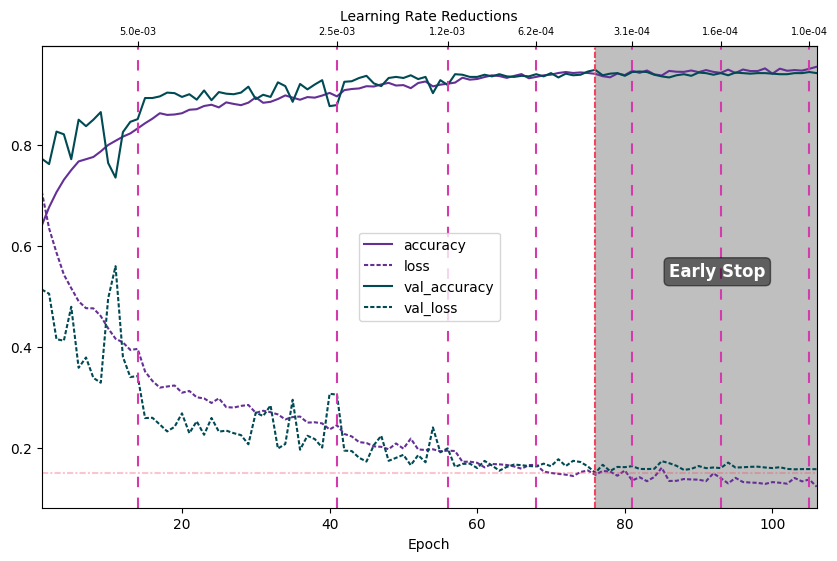

In [65]:
# Create dataframe of model fit history.
mod_dcnn_hist_df = pd.DataFrame().from_dict(mod_dcnn_hist.history, orient = 'columns')

plot_TF_training_history(mod_dcnn_hist_df)

In [66]:
y_pred_val_dcnn_proba = mod_dcnn.predict(np.stack(X_val.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_val_dcnn = y_pred_val_dcnn_proba.argmax(axis = 1)

accuracy_score(y_val, y_pred_val_dcnn)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


0.9485530546623794

In [70]:
y_pred_dcnn_proba = mod_dcnn.predict(np.stack(X_test.norm_flat.apply(flat_to_array)), verbose = "auto", callbacks = None)
y_pred_dcnn = y_pred_dcnn_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


## 8. Model Analysis and Feature Extraction Discussion: <a name="analysis"></a>

Filter Shape: (3, 3, 3, 16)


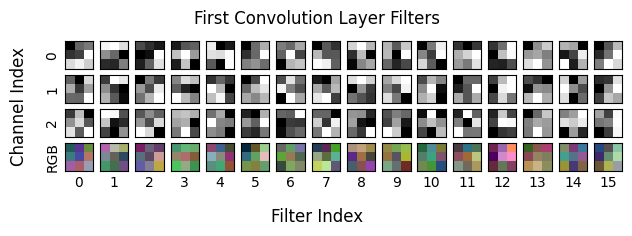

In [38]:
# Extract weights from first convolution. 
filters, biases = mod_cnn.layers[0].get_weights()
# Normalize values.
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('Filter Shape:', filters.shape)

# Plot all filters and channels.
n_filters = filters.shape[3]
fig, ax = plt.subplots(4, n_filters, sharey = True, sharex = True)

for i in range(n_filters):
    filters_rgb = filters[:,:,:,i]
    for j in range(3):
        ax[j,i].imshow(filters_rgb[:,:,j], cmap = 'gray')
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        if i == 0:
            ax[j,i].set_ylabel(j)
    ax[3,i].imshow(filters_rgb)
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    ax[3,i].set_xlabel(i)

ax[3,0].set_ylabel('RGB')
fig.supylabel('Channel Index')
fig.supxlabel('Filter Index', y = 0.25)
fig.suptitle('First Convolution Layer Filters', y = 0.7)
fig.tight_layout(h_pad = -14, w_pad = 0.5)
plt.show()

In [39]:
# Indexes of maxpool layers at end of conv blocks.
pool_idx = [2, 6]

outputs = [mod_cnn.layers[i].output for i in pool_idx]
mod_cnn_feat = tf.keras.Model(inputs = mod_cnn.inputs,
                       outputs = outputs)

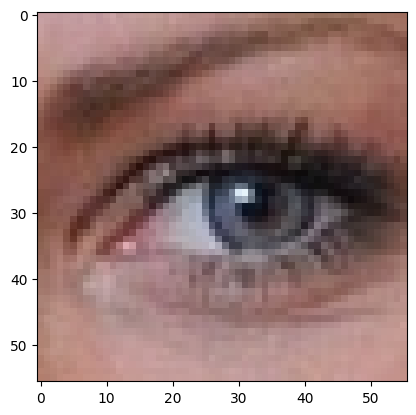

In [40]:
# Load unseen image.
img = Image.open('./Data/Female/186.jpg')
img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
img = np.asarray(img)
img = np.expand_dims(img, axis = 0)
plt.imshow(img[0,:,:,:])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Filter Shape: (1, 28, 28, 16)


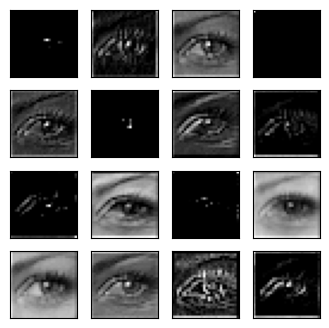

Filter Shape: (1, 14, 14, 32)


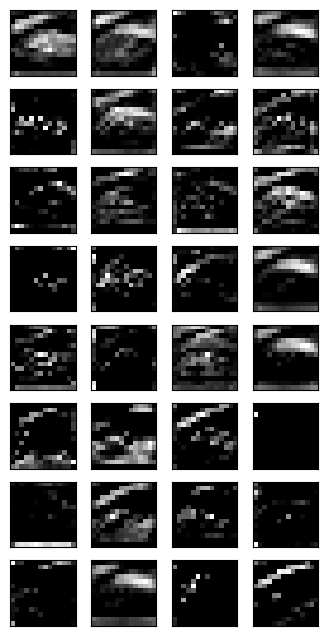

In [41]:
# Retrieve feature maps for image.
feature_maps = mod_cnn_feat.predict(img)
# Get number of filters from shape of filters = (16, 32).
n_filters = [feature_maps[0].shape[3], feature_maps[1].shape[3]]
# Iterate through each feature map.
for i, fmap in enumerate(feature_maps):
    print('Filter Shape:', fmap.shape)
    fig, ax = plt.subplots(int(n_filters[i]/4), 4, figsize = ((4,4) if i == 0 else (4,8)))
    # Iterate through number of filters in current fmap layer.
    for j in range(n_filters[i]):
        # Plot each filter feature map.
        ax[j//4, j%4].set_xticks([])
        ax[j//4, j%4].set_yticks([])
        ax[j//4, j%4].imshow(fmap[0,:,:,j], cmap = 'gray')

    plt.show()

In [68]:
# Get feature vector from model.
# https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
extractor = tf.keras.Model(inputs = mod_cnn.inputs,
                           outputs = [layer.output for layer in mod_cnn.layers])
features_test = extractor(np.stack(X_test.norm_flat.apply(flat_to_array)))

feature_vec_cnn = []
# Take feature vector from last fully connected layer.
for i in range(len(X_test)):
    feature_vec_cnn.append(features_test[8][i].numpy())

Extract deep learning embedding for PCA plot.

To be continued.. 

Visualize the resulting embeddings.

Explained Variance Ratios: [0.1970418  0.07594022]


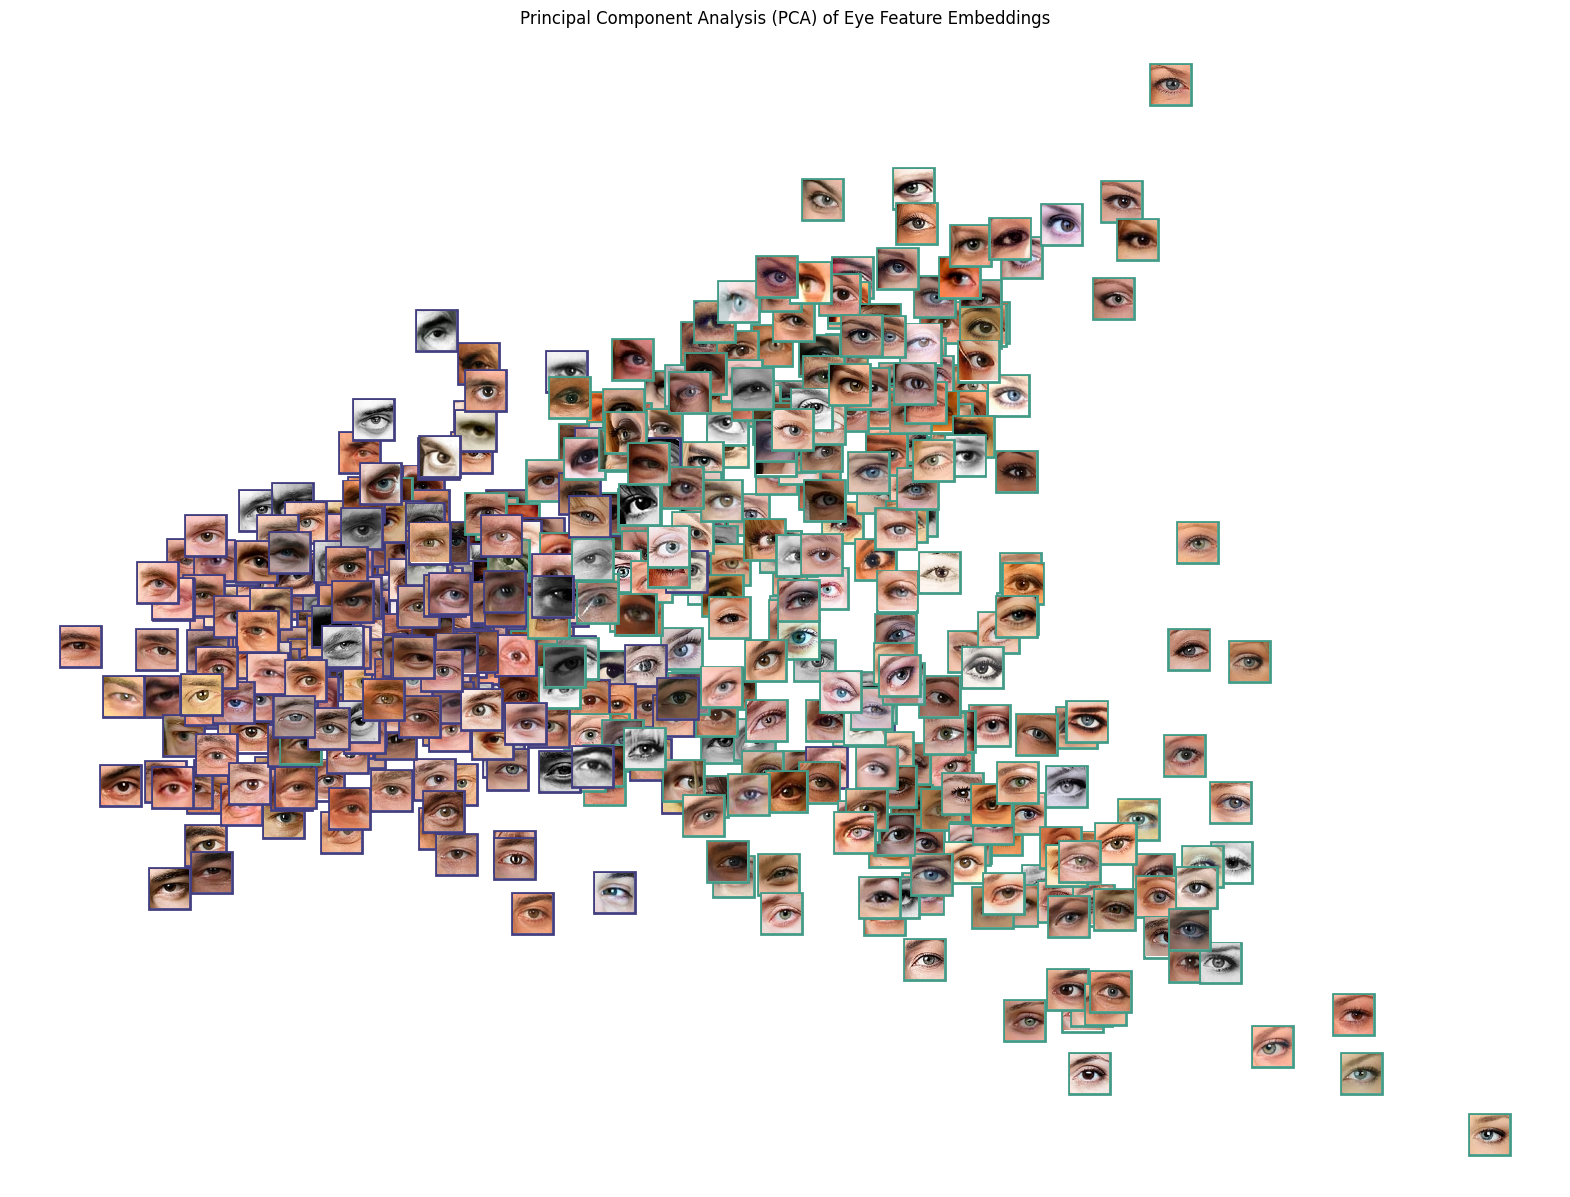

In [69]:
def pca_plot(features, image_arrays, zoom = 0.5, cmap = None, photos = True): #zoom = 0.125

    # Reduce dimensions to 2 using PCA.
    pca = PCA(n_components = 2)
    pca_fit = pca.fit_transform(features)
    print(f'Explained Variance Ratios: {pca.explained_variance_ratio_}')

    _, ax = plt.subplots(figsize = (20, 15), subplot_kw = {'aspect' : 'equal'})
    ax.scatter(pca_fit[:, 0], pca_fit[:, 1], c = cmap, alpha = 0.8)
    
    # Add eye photos to plot.
    if photos == True:
        for i, rgb_flat in enumerate(image_arrays):
            # Load image.
            image = Image.fromarray(rgb_flat.reshape(img_size,img_size,3))
            # Zoom out.
            im = OffsetImage(image, zoom = zoom)
            # Set class label color for edge bbox.
            bboxprops = ({'edgecolor' : cmap[i], 'lw' : 2} if cmap is not None else None)
            anno_bbox = AnnotationBbox(offsetbox = im, 
                                xy = pca_fit[i],
                                xycoords = 'data',
                                frameon = (bboxprops is not None),
                                pad = 0.075,
                                bboxprops = bboxprops)
            ax.add_artist(anno_bbox)

    ax.set_axis_off()
    ax.axis('tight')
    ax.set_title('Principal Component Analysis (PCA) of Eye Feature Embeddings')

    return ax

# Teal = Women, Purple = Men
cmap_sex_all = ['#439A86' if sex == 0 else '#423e80' for sex in y_test]

_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all)
plt.show()

Explained Variance Ratios: [0.1970418  0.07594022]


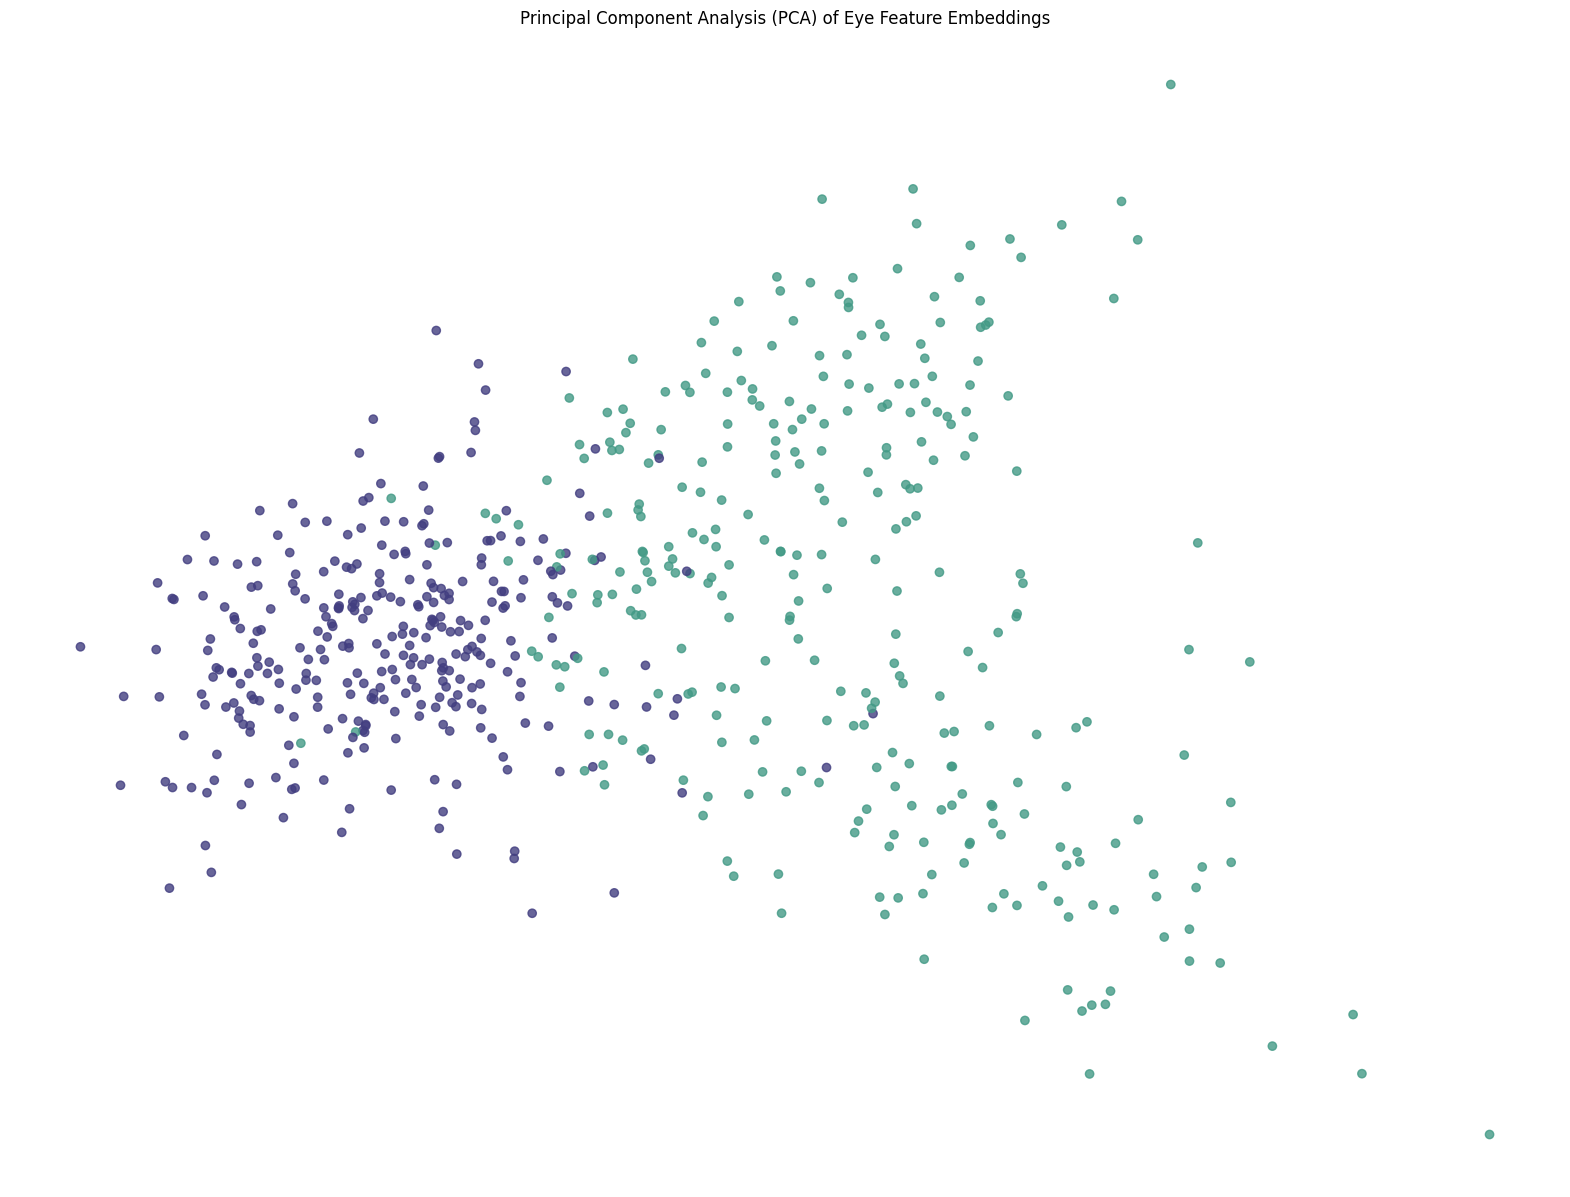

In [46]:
_ = pca_plot(feature_vec_cnn, X_test.rgb_flat.tolist(), cmap = cmap_sex_all, photos = False)
plt.show()

Misclassification Exploration

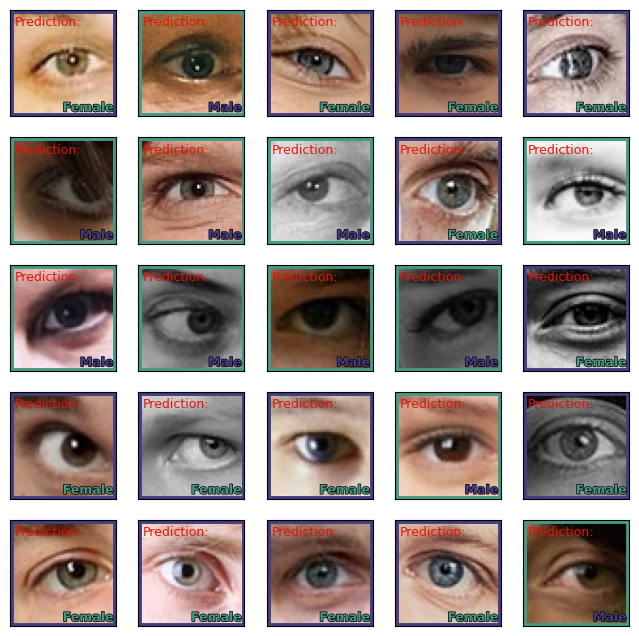

In [812]:
# Get mask for all misclassified images in test set.
mask_missed_cnn = y_test != y_pred_cnn
# Sample 25 images from misclassified images.
missed_real_labels = y_test[mask_missed_cnn].sample(25, random_state = 11)

cmap_sex_missed = ['#439A86' if sex == 0 else '#423e80' for sex in missed_real_labels]
class_map = {0: 'Female', 1: 'Male'}

fig, ax = plt.subplots(5, 5, figsize = (8,8))
# Use index to retrieve images and loop through.
for i, img in enumerate(X_test.loc[missed_real_labels.index].rgb_flat):
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])
    ax[i//5, i%5].imshow(flat_to_array(img))
    # Add border for real label.
    border = plt.Rectangle((0, 0), 55, 55,
                           fill = False,
                           color = cmap_sex_missed[i],
                           linewidth = 3.5)
    ax[i//5, i%5].add_patch(border)
    # Add text for incorrect predictions.
    ax[i//5, i%5].text(2, 8, 'Prediction:', fontsize = 9, color = '#e61405')
    ax[i//5, i%5].text(54, 53, (f"{class_map[1 - missed_real_labels.iloc[i]]}"),
                       fontsize = 9, 
                       weight = 'bold',
                       ha = 'right', 
                       color = cmap_sex[class_map[1 - missed_real_labels.iloc[i]]]
                       ).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                           path_effects.Normal()])
plt.show()

**Real Label:** The colored border of the image indicates the real class, consistent with all other visualizations.
- Teal = Female
- Purple = Male

**Predicted Label:** The text printed on the image.

## 9. Results <a name="results"></a>

---


In [127]:
# Plot confusion matrices of all models.
def confusion_matrix_subplot(y_pred_dict):
    model_class_vals = {}

    fig, ax = plt.subplots(int(np.ceil(len(y_pred_dict) / 2)), 2, figsize = (7, 7), sharey = True)
    for i, (model, y_pred) in enumerate(y_pred_dict.items()):
        y_true = y_test

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(ax = ax[i//2, i%2])
        disp.ax_.set_title(str(model))
        disp.im_.colorbar.remove()
        # Store classification metrics
        # In the order [tn, fp, fn, tp]
        model_class_vals[model] = list(confusion_matrix(y_true, y_pred, labels = y_true.unique().sort()).ravel())

    # Check if odd number of models and delete last subplot if true.
    if len(y_pred_dict) % 2 != 0:
        fig.delaxes(ax[i//2, (len(y_pred_dict) % 3)])
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0)
    fig.colorbar(disp.im_, ax = ax)
    fig.suptitle('Confusion Matrices of All Models')
    
    return model_class_vals

# Plot all model ROC curves.
def roc_curve_subplot(y_pred_proba_dict):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    for i, model in enumerate(y_pred_proba_dict.keys()):
        y_pred_proba_temp = y_pred_proba_dict[model][:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_temp)
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = f"AUC = {auc_score:0.3f} | {model}", alpha = 0.8)

    # Add 45 degree line for 0.5 AUC.
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

    ax.set_title('Test Set - ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.grid(alpha = 0.4)
    plt.legend(loc = 'center right')

    plt.show()

# Highlight the best model's test results green at each proportion.
def max_value_highlight(df):
    max_test_rows = df.max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df):
    # Sort values
    sorted_df = df.sort_values(ascending = False)
    top_two = sorted_df.iloc[:2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

In [138]:
y_pred_dict = {'KNN': y_pred_knn,
               'FNN': y_pred_fnn,
               'CNN': y_pred_cnn,
               'DCNN': y_pred_dcnn}

y_pred_proba_dict = {'KNN': y_pred_knn_proba,
                     'FNN': y_pred_fnn_proba,
                     'CNN': y_pred_cnn_proba,
                     'DCNN': y_pred_dcnn_proba}

y_pred_val_dict = {'KNN': y_pred_val_knn,
               'FNN': y_pred_val_fnn,
               'CNN': y_pred_val_cnn,
               'DCNN': y_pred_val_dcnn}

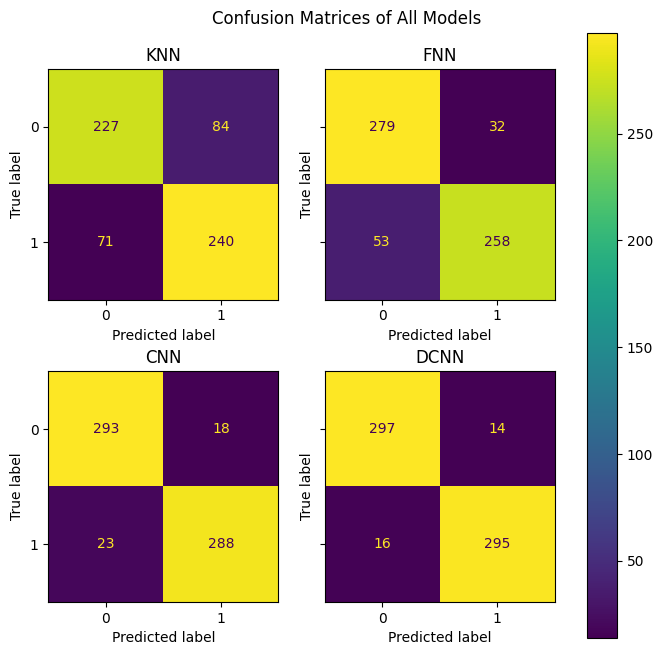

In [100]:
model_class_vals = confusion_matrix_subplot(y_pred_dict)

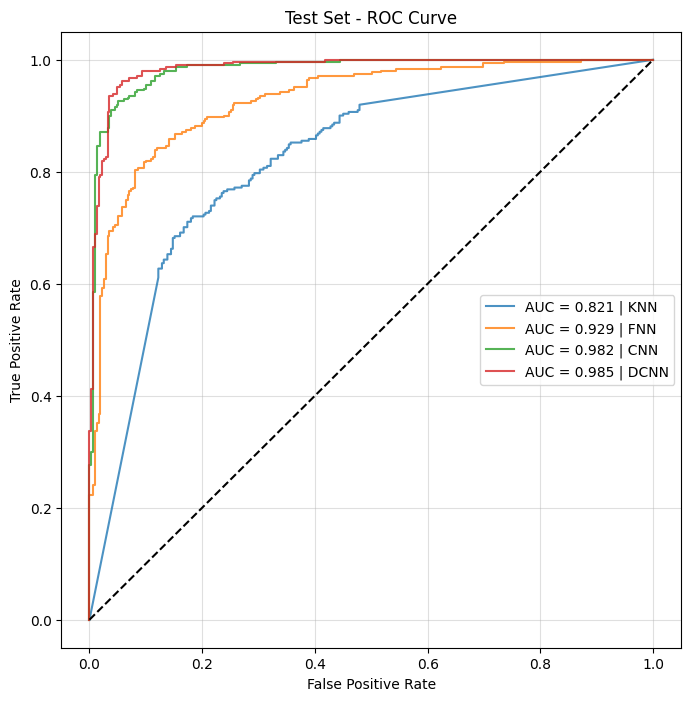

In [128]:
roc_curve_subplot(y_pred_proba_dict)

In [132]:
print('\n\n')
for model, y_pred in y_pred_dict.items():
    print(f'############ {model} ############')
    results = classification_report(y_test, y_pred, output_dict = True)
    display(pd.DataFrame().from_dict(results))




############ KNN ############


,0,1,accuracy,macro avg,weighted avg
precision,0.761745,0.740741,0.750804,0.751243,0.751243
recall,0.729904,0.771704,0.750804,0.750804,0.750804
f1-score,0.745484,0.755906,0.750804,0.750695,0.750695
support,311.000000,311.000000,0.750804,622.000000,622.000000


############ FNN ############


,0,1,accuracy,macro avg,weighted avg
precision,0.840361,0.889655,0.863344,0.865008,0.865008
recall,0.897106,0.829582,0.863344,0.863344,0.863344
f1-score,0.867807,0.858569,0.863344,0.863188,0.863188
support,311.000000,311.000000,0.863344,622.000000,622.000000


############ CNN ############


,0,1,accuracy,macro avg,weighted avg
precision,0.927215,0.941176,0.934084,0.934196,0.934196
recall,0.942122,0.926045,0.934084,0.934084,0.934084
f1-score,0.934609,0.933549,0.934084,0.934079,0.934079
support,311.000000,311.000000,0.934084,622.000000,622.000000


############ DCNN ############


,0,1,accuracy,macro avg,weighted avg
precision,0.948882,0.954693,0.951768,0.951787,0.951787
recall,0.954984,0.948553,0.951768,0.951768,0.951768
f1-score,0.951923,0.951613,0.951768,0.951768,0.951768
support,311.000000,311.000000,0.951768,622.000000,622.000000


In [140]:
results_dict = {}
for model, y_pred in y_pred_dict.items():
        val_acc = accuracy_score(y_val, y_pred_val_dict[model])
        test_acc = accuracy_score(y_test, y_pred)
        results_dict[model] = [val_acc, test_acc]

results_df = pd.DataFrame().from_dict(results_dict, orient = 'index', columns = ['Val Accuracy', 'Test Accuracy'])
results_df.style.apply(highlight_top_two).apply(max_value_highlight)

,Val Accuracy,Test Accuracy
KNN,0.773848,0.750804
FNN,0.863880,0.863344
CNN,0.946409,0.934084
DCNN,0.948553,0.951768


## 10. Conclusion <a name="conclusion"></a>

---

### 10.1. Limitations: <a name="limitations"></a>

### 10.2. Future Work: <a name="future"></a>

- A larger dataset would help alleviate some of the issues described above and possibly help models classify those hard misclassified examples.
- Find or compile a higher resolution dataset.
- Instead of using images of the periocular region, segment the iris and attempt to classify only using that masked segmentation. This has been shown to work but many current studies show biased methodologies and end with conflicting conclusions on this subject. It seems data leakage, poor segmentation leading to other characteristics to bleed into the models, tends to be the biggest issue with current studies.
- Perform more tests to confound these models to determine how much weight is given to characteristics like makeup or eyelash contrast vs eye and eyebrow shape.

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. 2016 paper iris sex classification based on in-depth feature selection and SVM: https://ieeexplore.ieee.org/abstract/document/7447785
2. 2018 paper iris sex classification based on Zernike moments and classifying using SVM and KNN: https://ieeexplore.ieee.org/document/8492757
3. 2019 paper iris .. using CNNs and image augmentation: https://ieeexplore.ieee.org/abstract/document/7447785
4. 2023 paper classifcation using periocular region and iris using pre-trained CNNs and transfer learning: https://www.sciencedirect.com/science/article/pii/S2666307423000268
5. 2019 Paper refuting previous papers claims on classifications based solely on iris; claiming periocular features were included: https://ieeexplore.ieee.org/document/8659186
6. Great examples of utilizing matplotlib to plot PCA/t-SNE tied to their images https://www.kaggle.com/code/hmendonca/proper-clustering-with-facenet-embeddings-eda
7. Local Binary Patterns used for feature extraction: https://en.wikipedia.org/wiki/Local_binary_patterns
8. Sobel filter edge detector: https://en.wikipedia.org/wiki/Sobel_operator

Alternative Datasets that would improve this project and allow for more nuanced segmentation of eye features:
1. Biometrics Research of Notre Dame has a high quality dataset. Behind a license application: https://cvrl.nd.edu/projects/data/
2. Another dataset with high-resolution iris photos. Behind license and too big for this project, though: https://ieee-dataport.org/documents/iris-super-resolution-dataset